In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from selenium import webdriver as wb
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import datetime
import time
from wordcloud import WordCloud

## ÎπÑÌä∏ÏΩîÏù∏Í≥º ÏïàÏ†ïÏûêÏÇ∞, ÏúÑÌóòÏûêÏÇ∞Ïùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù
- Îç∞Ïù¥ÌÑ∞ ÏÇ∞Ï∂ú Í∏∞Í∞Ñ
    - Ï†úÎèÑ Ìé∏ÏûÖ Ï†Ñ : 2014.09.01 ~ 2019.12.31
    - Ï†úÎèÑ Ìé∏ÏûÖ ÌõÑ : 2021.01.01 ~ 2024.06.06
- ÏïàÏ†ÑÏûêÏÇ∞ ÎπÑÍµêÍµ∞ : Í∏à, Îã¨Îü¨
- ÏúÑÌóòÏûêÏÇ∞ ÎπÑÍµêÍµ∞ : ÏõêÏú†
- Îç∞Ïù¥ÌÑ∞ Ï∂úÏ≤ò : Yahoo Finance

In [2]:
# Í∏∞Í∞Ñ
start_date = "2014-09-01"
end_date = "2019-12-31"
news_date_list = []

# Ï¢ÖÎ™©
bitcoin = "BTC-USD"
gold = "GC=F"
usd = "EURUSD=X"
wti = "CL=F"

# ÏùºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
def ticker_data(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de)
    result["change"] = result["Adj Close"].diff()
    result["daily_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna() # NaN Ìè¨Ìï® Ìñâ ÏÇ≠Ï†ú
    return result

# Ï£ºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
def ticker_data_wk(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de, interval = "1wk")
    result["weekly_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna()
    return result

# ÏùºÎ≥Ñ ÏàòÏ†ï Ï¢ÖÍ∞Ä (Adj Close) Ï∂îÏ∂ú Ìï®Ïàò
def daily_adj_close(tk_name, ds, de) :
    result = yf.download(tk_name, ds, de)
    return result["Adj Close"]

# ÏùºÎ≥Ñ ÏàòÏùµÎ•† (daily_return) Ï∂îÏ∂ú Ìï®Ïàò
def daily_return_rate(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de)
    return result["daily_return"]

# Ï£ºÍ∞Ñ ÏàòÏùµÎ•† (weekly_return) Ï∂îÏ∂ú Ìï®Ïàò
def weekly_return_rate(tk_name, ds, de) :
    result = ticker_data_wk(tk_name, ds, de)
    return result["weekly_return"]

# ÎπÑÌä∏ÏΩîÏù∏Í≥º Ìã∞Ïª§ Í∞ÑÏùò ÏÉÅÍ¥ÄÏÑ± ÏÇ∞Ï∂ú
def corr_bit(tk_name, ds, de) :
    result = weekly_return_rate("BTC-USD", ds, de) / weekly_return_rate(tk_name, ds, de)
    result = result.dropna()
    return result

# Í≥ÑÏÇ∞Ïãù for ÏÑ†Ìòï ÌöåÍ∑Ä
def lin_cal(tk_name, ds, de) :
    tk2019 = ticker_data(tk_name, ds, de) # Ï†úÎèÑ Ìé∏ÏûÖ ÌõÑ Í∏∞Í∞ÑÏùò Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    std2019 = tk2019[tk2019.index == "2019-11-15"] # Í∏∞Ï§ÄÏù¥ ÎêòÎäî ÎÇ†ÏßúÏùò Ìñâ Ï∂îÏ∂ú
    std2019 = std2019["Adj Close"].values[0] # Ìï¥Îãπ ÌñâÏùò ÏàòÏ†ï Ï¢ÖÍ∞Ä
    result = (ticker_data(tk_name, ds, de)["Adj Close"] / std2019) * 100 # Ìã∞Ïª§Ïùò ÏàòÏ†ï Ï¢ÖÍ∞Ä Ïª¨ÎüºÍ≥º Ïó∞ÏÇ∞
    return result

# Ìã∞Ïª§ ÏÉùÏÑ± Ïãú Ìò∏Ï∂ú Ìï®Ïàò
def ticker_call(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de) # ÏùºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    result["chg_rat_exp_2019"] = lin_cal(tk_name, ds, de) # ÏÑ†Ìòï ÌöåÍ∑Ä ÏÇ∞Ï∂úÏùÑ ÏúÑÌï¥ Ïó∞ÏÇ∞Îêú Ïª¨Îüº Ï∂îÍ∞Ä
    return result

# ÏÑ†Ìòï ÌöåÍ∑Ä Í≥ÑÏàò ÏÇ∞Ï∂ú
def lin_data(tk_name, ds, de) :
    bit_col = ticker_call(bitcoin, ds, de)["chg_rat_exp_2019"]
    tk_col = ticker_call(tk_name, ds, de)["chg_rat_exp_2019"]
    
    result = pd.concat([bit_col, tk_col], axis = 1)
    result.columns = ["bit", "tk"]
    result = result.dropna()
    
    model = stats.linregress(result["bit"], result["tk"])
    dict_lin = {
        "slope" : model.slope,
        "intercept" : model.intercept,
        "rvalue" : model.rvalue,
        "pvalue" : model.pvalue,
        "stderr" : model.stderr,
        "intercept_stderr" : model.intercept_stderr
    }
    result_lin = pd.DataFrame(list(dict_lin.values()), index = dict_lin.keys())
    return result_lin

In [3]:
# ÎπÑÌä∏ÏΩîÏù∏Ïùò ÏùºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
bit_ticker = ticker_call(bitcoin, start_date, end_date)
bit_ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-09-18   456.859985   456.859985   413.104004   424.440002   424.440002   
2014-09-19   424.102997   427.834991   384.532013   394.795990   394.795990   
2014-09-20   394.673004   423.295990   389.882996   408.903992   408.903992   
2014-09-21   408.084991   412.425995   393.181000   398.821014   398.821014   
2014-09-22   399.100006   406.915985   397.130005   402.152008   402.152008   
...                 ...          ...          ...          ...          ...   
2019-12-26  7274.799316  7388.302734  7200.386719  7238.966797  7238.966797   
2019-12-27  7238.141113  7363.529297  7189.934082  7290.088379  7290.088379   
2019-12-28  7289.031250  7399.041016  7286.905273  7317.990234  7317.990234   
2019-12-29  7317.647461  7513.948242  7279.865234  7422.652832  7422.652832   
2019-12-30  7420.272949  7454.824219  7276.308105  7292.995117  7292.995117   

                 Volume      change  daily_return  chg_rat_exp_2019  
Date                                                                 
2014-09-18     34483200  -32.894012     -7.192558          4.998121  
2014-09-19     37919700  -29.644012     -6.984265          4.649039  
2014-09-20     36863600   14.108002      3.573492          4.815172  
2014-09-21     26580100  -10.082977     -2.465854          4.696436  
2014-09-22     24127600    3.330994      0.835210          4.735662  
...                 ...         ...           ...               ...  
2019-12-26  22787010034  -36.188965     -0.497432         85.244624  
2019-12-27  22777360996   51.121582      0.706200         85.846621  
2019-12-28  21365673026   27.901855      0.382737         86.175188  
2019-12-29  22445257702  104.662598      1.430210         87.407674  
2019-12-30  22874131672 -129.657715     -1.746784         85.880851  

[1930 rows x 9 columns]

In [4]:
# ÎπÑÍµêÍµ∞ ÏùºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
ticker = ticker_call(usd, start_date, end_date)
ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open      High       Low     Close  Adj Close  Volume  \
Date                                                                    
2014-09-02  1.313198  1.313731  1.311180  1.313198   1.313198       0   
2014-09-03  1.313094  1.316099  1.312405  1.313198   1.313198       0   
2014-09-04  1.314924  1.315500  1.292420  1.315097   1.315097       0   
2014-09-05  1.293042  1.298819  1.292674  1.293276   1.293276       0   
2014-09-08  1.295203  1.295874  1.293169  1.295337   1.295337       0   
...              ...       ...       ...       ...        ...     ...   
2019-12-24  1.109299  1.109755  1.107064  1.109385   1.109385       0   
2019-12-25  1.109139  1.110864  1.107788  1.109016   1.109016       0   
2019-12-26  1.109509  1.110494  1.108279  1.109545   1.109545       0   
2019-12-27  1.110124  1.118068  1.110000  1.110112   1.110112       0   
2019-12-30  1.118155  1.122070  1.118155  1.118230   1.118230       0   

              change  daily_return  chg_rat_exp_2019  
Date                                                  
2014-09-02  0.000414      0.031519        119.159550  
2014-09-03  0.000000      0.000000        119.159550  
2014-09-04  0.001900      0.144664        119.331930  
2014-09-05 -0.021821     -1.659280        117.351880  
2014-09-08  0.002061      0.159327        117.538853  
...              ...           ...               ...  
2019-12-24  0.001401      0.126473        100.665627  
2019-12-25 -0.000369     -0.033268        100.632138  
2019-12-26  0.000529      0.047715        100.680155  
2019-12-27  0.000566      0.051055        100.731557  
2019-12-30  0.008119      0.731324        101.468231  

[1387 rows x 9 columns]

## ÏÑ†Ìòï ÌöåÍ∑Ä

In [5]:
# ÏÑ†Ìòï ÌöåÍ∑Ä Í≥ÑÏàò ÏÇ∞Ï∂ú
gold_lin = lin_data(gold, start_date, end_date)
usd_lin = lin_data(usd, start_date, end_date)
wti_lin = lin_data(wti, start_date, end_date)

df_lin = pd.concat([gold_lin, usd_lin, wti_lin], axis = 1)
df_lin.columns = ["Gold", "EUR/USD", "WTI"]
df_lin

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Gold       EUR/USD           WTI
slope              8.806704e-02  3.280201e-02  1.718436e-01
intercept          8.209459e+01  1.016624e+02  8.637515e+01
rvalue             6.159197e-01  3.322024e-01  4.252167e-01
pvalue            2.034304e-139  8.815676e-37  1.926592e-59
stderr             3.094584e-03  2.513448e-03  1.004486e-02
intercept_stderr   1.984151e-01  1.613809e-01  6.448459e-01

## Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞ÅÌôî

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


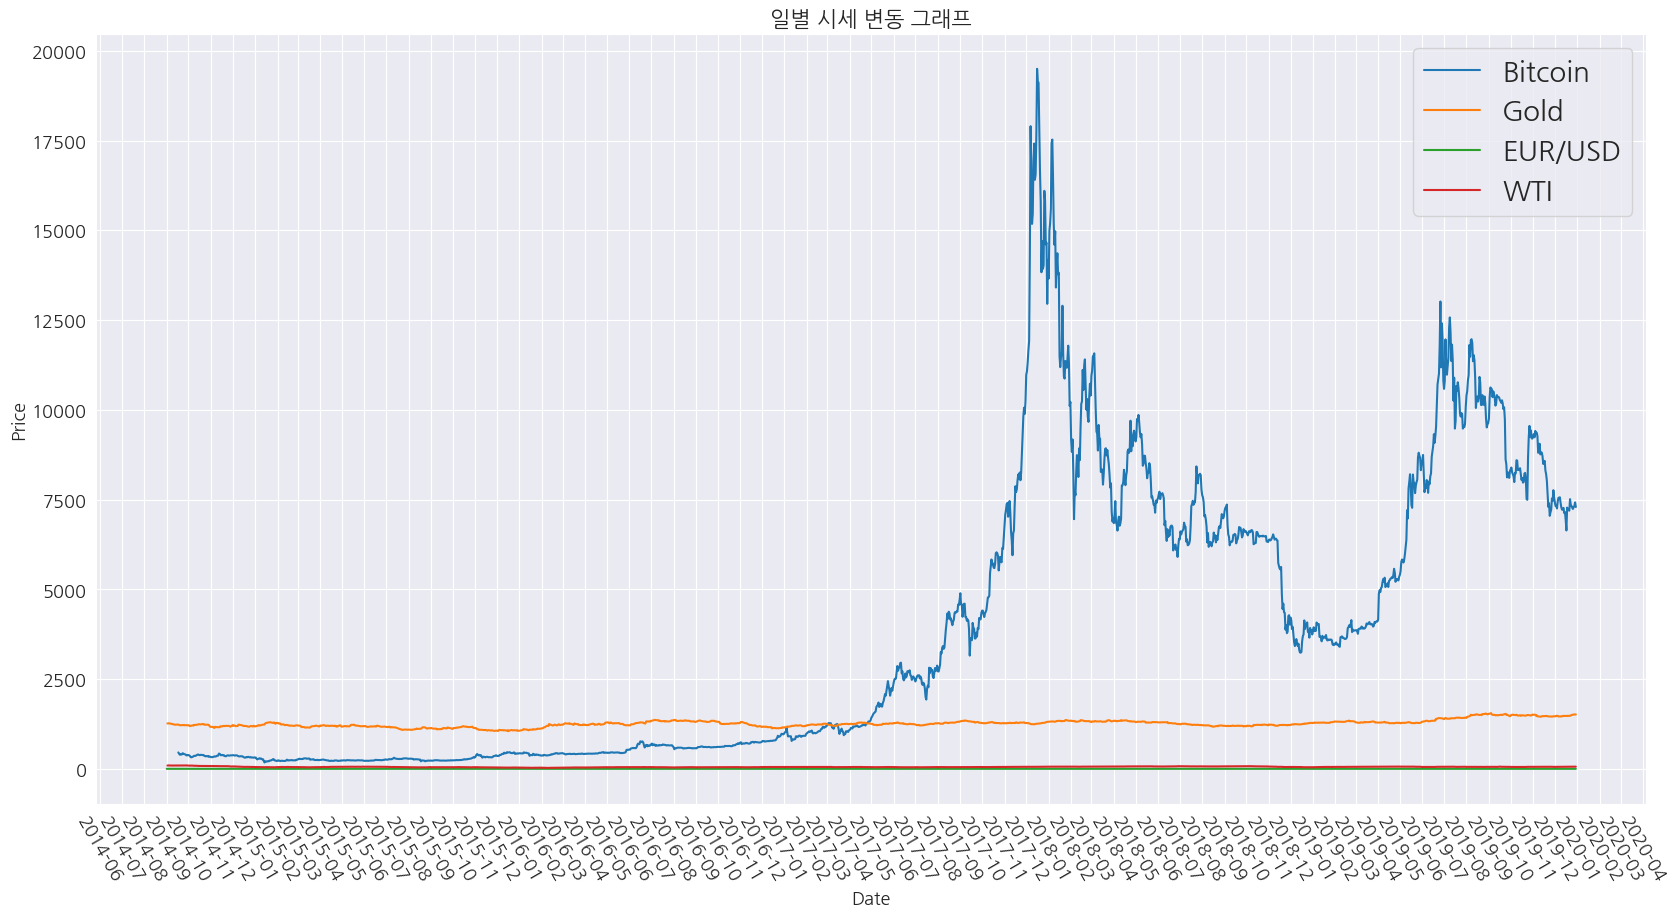

In [6]:
# daily price change graph
y1 = daily_adj_close(bitcoin, start_date, end_date)
y2 = daily_adj_close(gold, start_date, end_date)
y3 = daily_adj_close(usd, start_date, end_date)
y4 = daily_adj_close(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(y1.index, y1, label = "Bitcoin")
plt.plot(y2.index, y2, label = "Gold")
plt.plot(y3.index, y3, label = "EUR/USD")
plt.plot(y4.index, y4, label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("ÏùºÎ≥Ñ ÏãúÏÑ∏ Î≥ÄÎèô Í∑∏ÎûòÌîÑ")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


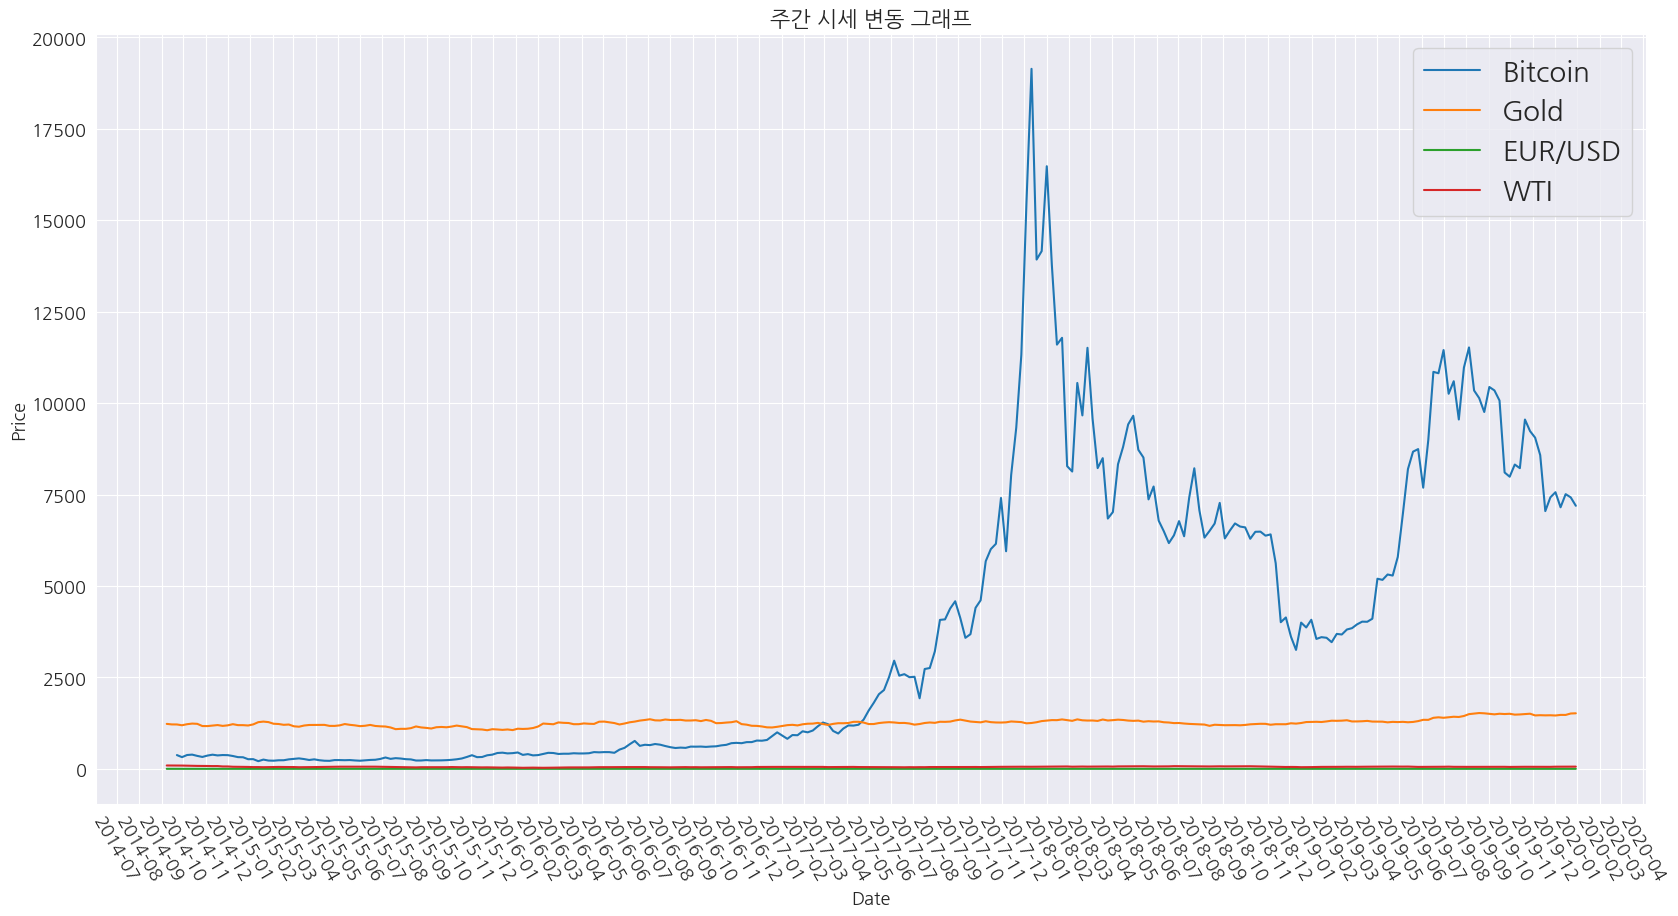

In [7]:
# weekly price change graph
y1_wk = ticker_data_wk(bitcoin, start_date, end_date)["Adj Close"]
y2_wk = ticker_data_wk(gold, start_date, end_date)["Adj Close"]
y3_wk = ticker_data_wk(usd, start_date, end_date)["Adj Close"]
y4_wk = ticker_data_wk(wti, start_date, end_date)["Adj Close"]

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(y1_wk.index, y1_wk, label = "Bitcoin")
plt.plot(y2_wk.index, y2_wk, label = "Gold")
plt.plot(y3_wk.index, y3_wk, label = "EUR/USD")
plt.plot(y4_wk.index, y4_wk, label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("Ï£ºÍ∞Ñ ÏãúÏÑ∏ Î≥ÄÎèô Í∑∏ÎûòÌîÑ")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


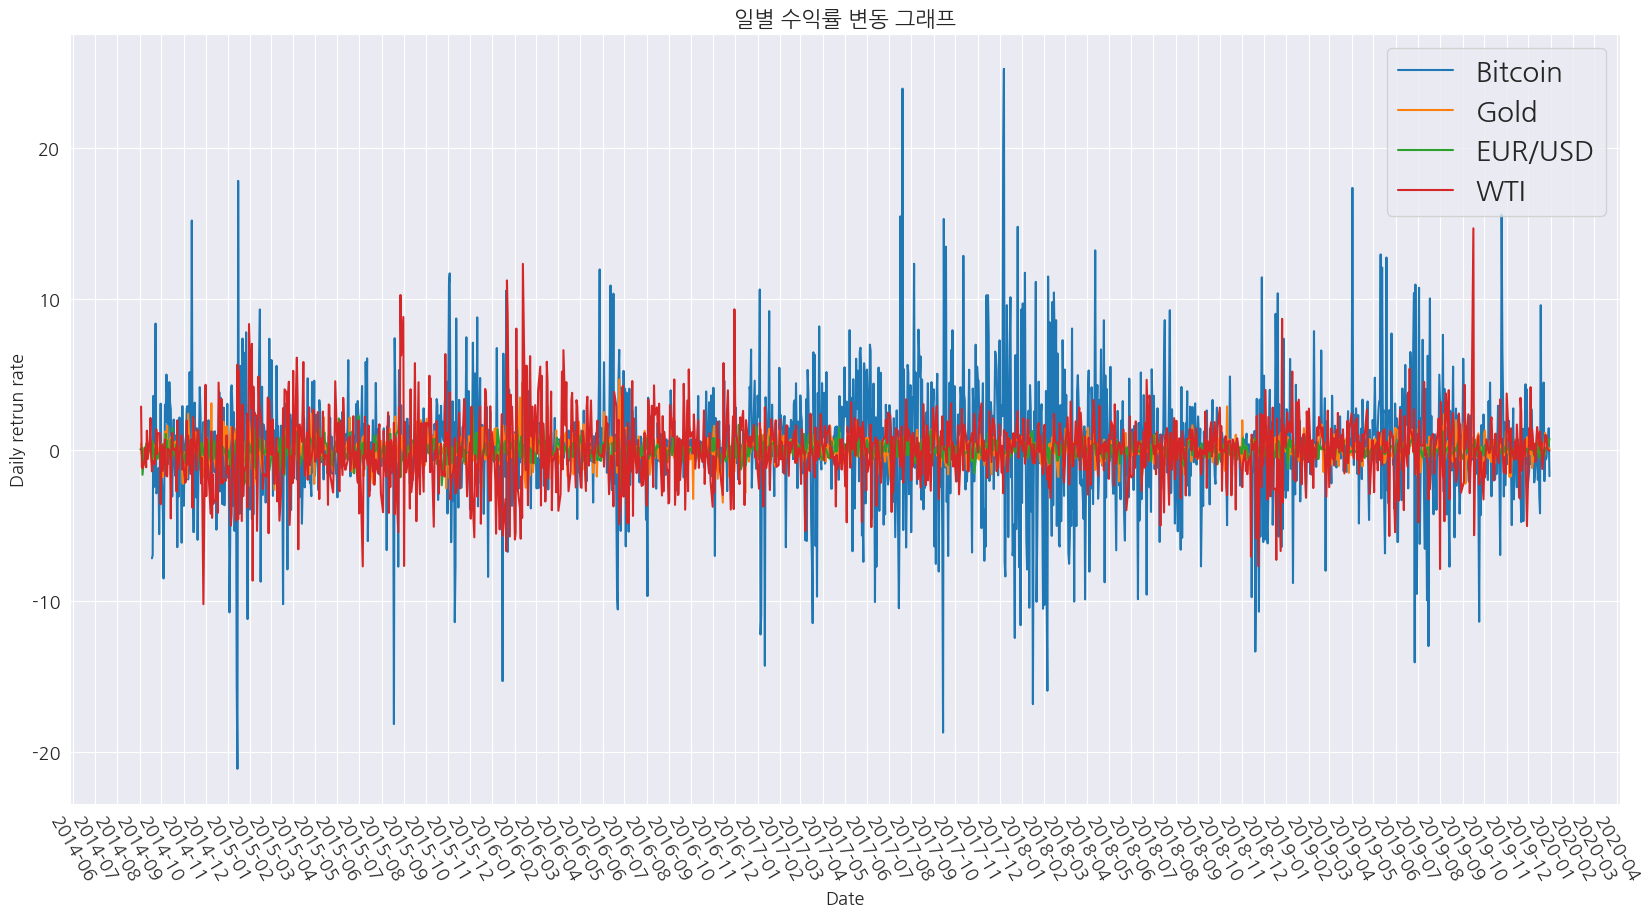

In [8]:
# daily return rate change graph
# ÏùºÎ≥Ñ ÏàòÏùµÎ•†(=Ï¶ùÍ∞êÎ•†)Ïùò Î≥ÄÎèôÏÑ± ÌôïÏù∏
d_y1 = daily_return_rate(bitcoin, start_date, end_date)
d_y2 = daily_return_rate(gold, start_date, end_date)
d_y3 = daily_return_rate(usd, start_date, end_date)
d_y4 = daily_return_rate(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(d_y1.index, d_y1, label = "Bitcoin")
plt.plot(d_y2.index, d_y2, label = "Gold")
plt.plot(d_y3.index, d_y3, label = "EUR/USD")
plt.plot(d_y4.index, d_y4, label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Daily retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("ÏùºÎ≥Ñ ÏàòÏùµÎ•† Î≥ÄÎèô Í∑∏ÎûòÌîÑ")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


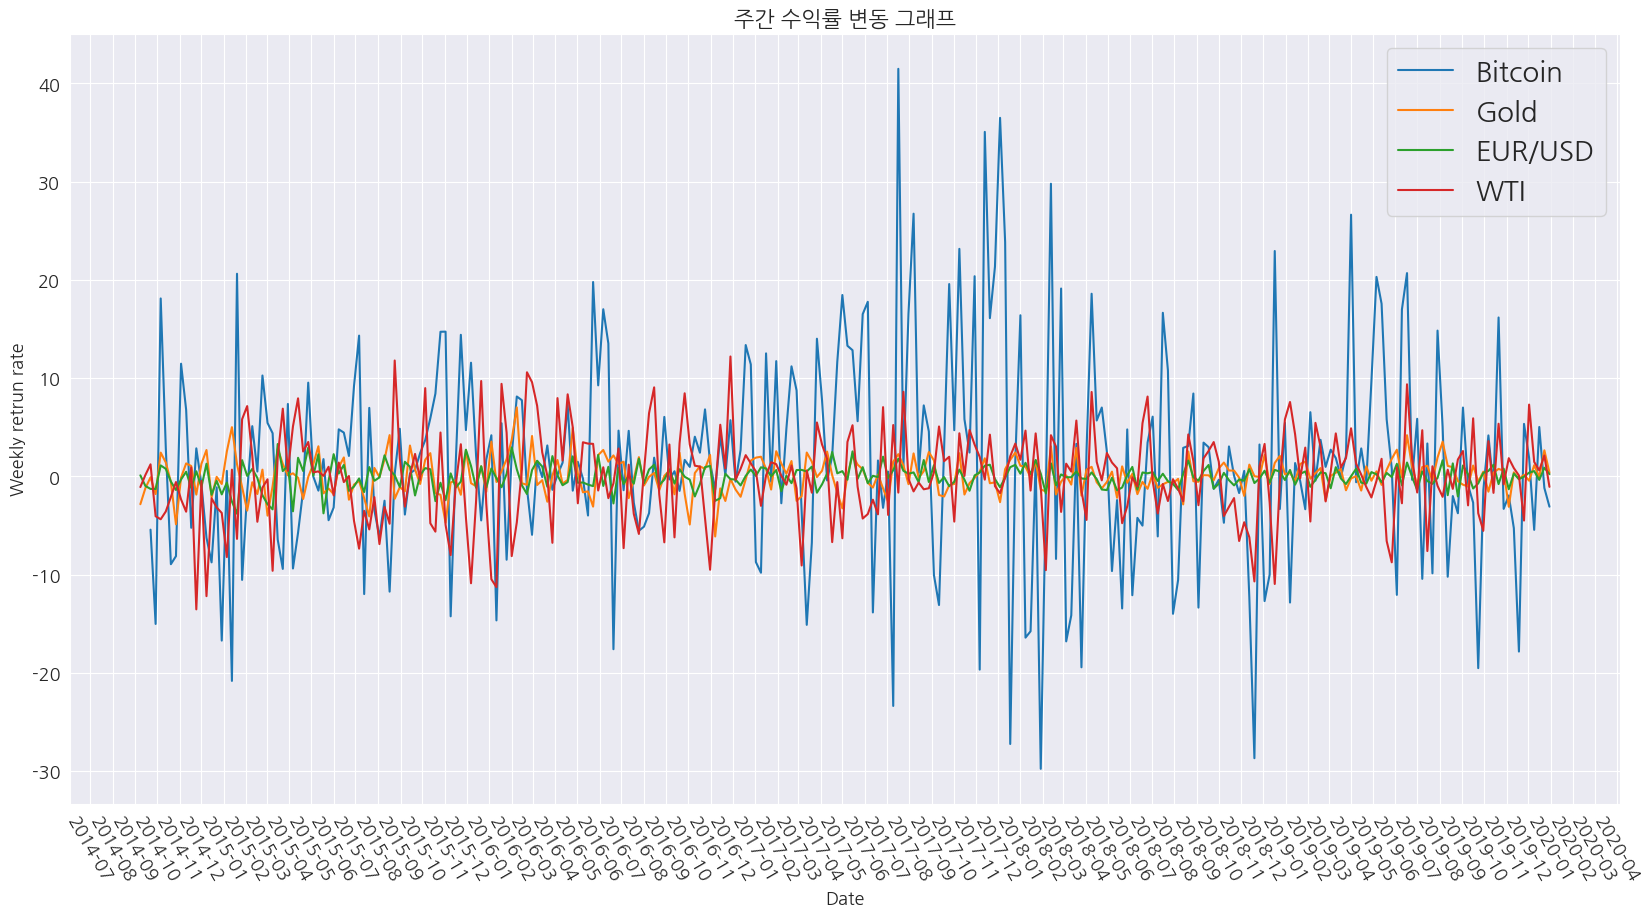

In [9]:
# weekly return rate change graph
# Ï£ºÍ∞Ñ ÏàòÏùµÎ•† (=Ï¶ùÍ∞êÎ•†)Ïùò Î≥ÄÎèôÏÑ± ÌôïÏù∏
w_y1 = weekly_return_rate(bitcoin, start_date, end_date)
w_y2 = weekly_return_rate(gold, start_date, end_date)
w_y3 = weekly_return_rate(usd, start_date, end_date)
w_y4 = weekly_return_rate(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(w_y1.index, w_y1, label = "Bitcoin")
plt.plot(w_y2.index, w_y2, label = "Gold")
plt.plot(w_y3.index, w_y3, label = "EUR/USD")
plt.plot(w_y4.index, w_y4, label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Weekly retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("Ï£ºÍ∞Ñ ÏàòÏùµÎ•† Î≥ÄÎèô Í∑∏ÎûòÌîÑ")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


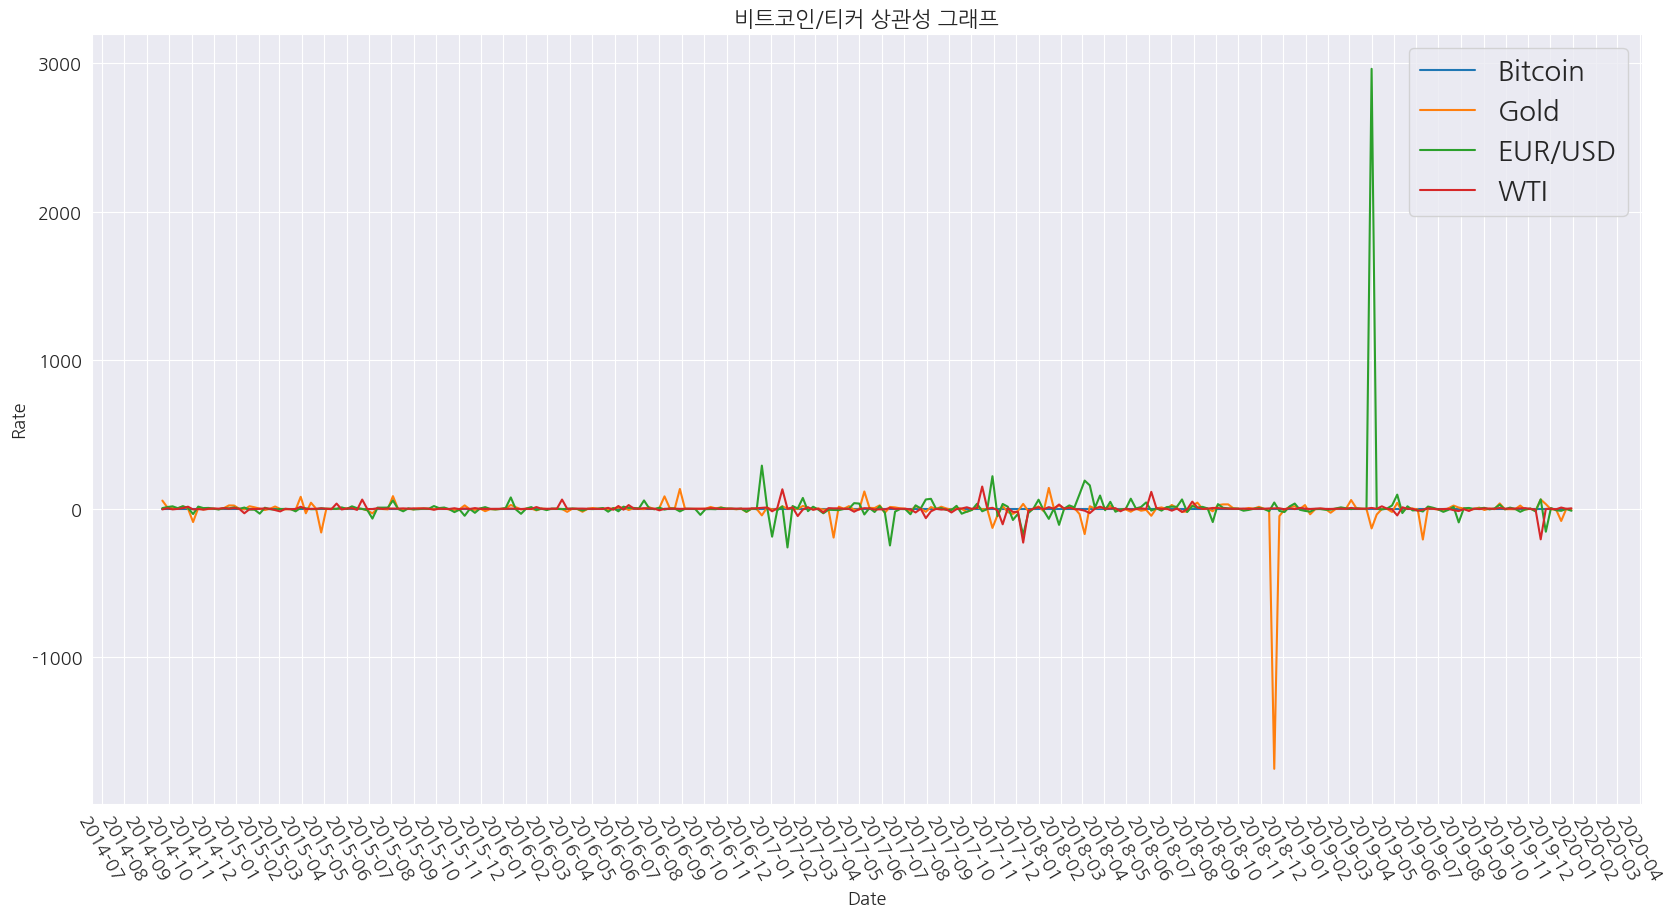

In [10]:
# ÏÉÅÍ¥ÄÏÑ± Í∑∏ÎûòÌîÑ ÏãúÍ∞ÅÌôî
# weekly_return_rate(Bitcoin) / weekly_return_rate(ticker)
corr_y1 = corr_bit(bitcoin, start_date, end_date)
corr_y2 = corr_bit(gold, start_date, end_date)
corr_y3 = corr_bit(usd, start_date, end_date)
corr_y4 = corr_bit(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(corr_y1.index, corr_y1, label = "Bitcoin")
plt.plot(corr_y2.index, corr_y2, label = "Gold")
plt.plot(corr_y3.index, corr_y3, label = "EUR/USD")
plt.plot(corr_y4.index, corr_y4, label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("ÎπÑÌä∏ÏΩîÏù∏/Ìã∞Ïª§ ÏÉÅÍ¥ÄÏÑ± Í∑∏ÎûòÌîÑ")
plt.show()

## ÌîºÏñ¥Ïä® ÏÉÅÍ¥Ä Í≥ÑÏàò
    - Í∞Å Ï¢ÖÎ™©Îì§ Í∞Ñ ÏÉÅÍ¥Ä Í≥ÑÏàò Î∂ÑÏÑù
    - ÏÉÅÍ¥Ä Í≥ÑÏàòÏùò ÏàòÏπòÍ∞Ä 0.3 ~ 0.7 Ïù¥Î©¥ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÏûàÎã§Í≥† Î¥Ñ (ÏïΩÌï® ~ Ï§ëÍ∞Ñ Ï†ïÎèÑÏùò ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ)

In [11]:
# ÎπÑÌä∏ÏΩîÏù∏Í≥º Ìã∞Ïª§Ïùò ÏÉÅÍ¥Ä Í≥ÑÏàò ÏÇ∞Ï∂ú
df_close = pd.concat([bit_ticker["Adj Close"], ticker["Adj Close"]], axis = 1)
df_close.columns = ["bit_adj_close", "tk_adj_close"]
df_close = df_close.dropna()
corr_coefficient = np.corrcoef(df_close["bit_adj_close"], df_close["tk_adj_close"])[0, 1]
print(f"ÎπÑÌä∏ÏΩîÏù∏Í≥ºÏùò ÏÉÅÍ¥Ä Í≥ÑÏàò : {corr_coefficient:.4f}")

ÎπÑÌä∏ÏΩîÏù∏Í≥ºÏùò ÏÉÅÍ¥Ä Í≥ÑÏàò : 0.3322


### üî• HeatMap ÏÉùÏÑ±

#### ‚úÖ ÏïàÏ†ÑÏûêÏÇ∞ ÎπÑÍµêÍµ∞ Ï∂îÍ∞Ä
- iShares 20+ Year Treasury Bond ETF : ÎØ∏Íµ≠ Íµ≠Ï±Ñ ETF, ÎØ∏Íµ≠Ïùò Ïû•Í∏∞ Íµ≠Ï±ÑÏóê Ìà¨ÏûêÌïòÏó¨ ÏïàÏ†ïÏ†ÅÏù∏ ÏàòÏùµÏùÑ Ï∂îÍµ¨, Ï¢ÖÎ™©ÏΩîÎìú "TLT"
- Dow Jones Industrial Average : Îã§Ïö∞Ï°¥Ïä§ ÏÇ∞ÏóÖ ÌèâÍ∑† ÏßÄÏàò, Ï£ºÎ°ú ÎåÄÌòï Í∏∞ÏóÖÎì§Î°ú Íµ¨ÏÑ±ÎêòÏñ¥ ÏûàÏñ¥, ÏãúÏû• Ï†ÑÏ≤¥Î≥¥Îã§Îäî Ï£ºÎ°ú ÎåÄÌòïÏ£º Î∞è ÏÇ∞ÏóÖÏùÑ ÎåÄÌëú, Ï¢ÖÎ™©ÏΩîÎìú "^DJI"
- Gold ETF : ÎÇòÏä§Îã• 100 ÏßÄÏàòÎ•º Ï∂îÏ¢ÖÌïòÎäî ETF, Í∏à Í∞ÄÍ≤©Ïóê Ïó∞ÎèôÎêòÏñ¥ Í∏àÏóê Ìà¨ÏûêÌïòÎäî Ìö®Í≥ºÎ•º Ï†úÍ≥µÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "GLD"

#### ‚úÖ ÏúÑÌóòÏûêÏÇ∞ ÎπÑÍµêÍµ∞ Ï∂îÍ∞Ä
- Î∏åÎ†åÌä∏Ïú† :  Ï¢ÖÎ™©ÏΩîÎìú "BZ=F"
- Tesla :  Ï¢ÖÎ™©ÏΩîÎìú "TSLA"
- Nasdaq-100 Index : ÎÇòÏä§Îã• 100 ÏßÄÏàòÎ•º Ï∂îÏ¢ÖÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "QQQ"
- Emerging Markets ETF : Ï§ëÍµ≠, Ïù∏ÎèÑ, Î∏åÎùºÏßà Îì± Ïã†Ìù• ÏãúÏû•Ïùò Ï£ºÏãùÏóê Ìà¨ÏûêÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "EEM"

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


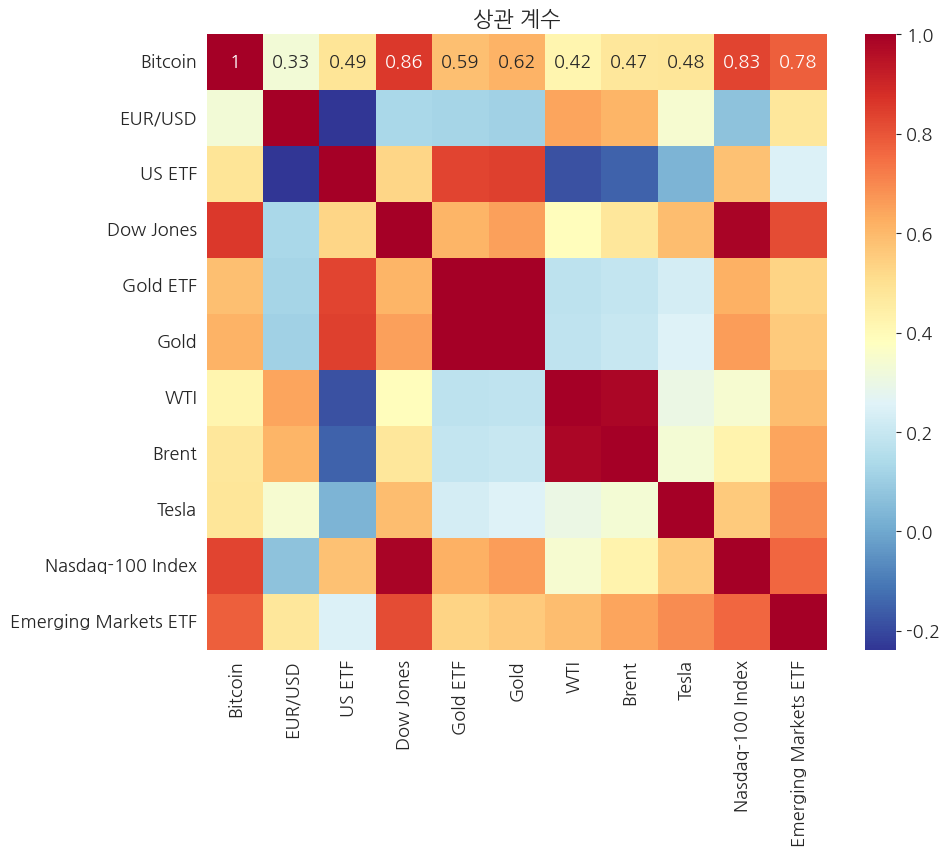

In [12]:
# ÏÉÅÍ¥Ä Í≥ÑÏàò ÏãúÍ∞ÅÌôî - HeatMep
corr_matrix = pd.DataFrame({"Bitcoin" : daily_adj_close(bitcoin, start_date, end_date),
                            # ÏïàÏ†ÑÏûêÏÇ∞
                            "EUR/USD" : daily_adj_close(usd, start_date, end_date),
                            "US ETF" : daily_adj_close("TLT", start_date, end_date),
                            "Dow Jones" : daily_adj_close("^DJI", start_date, end_date),
                            "Gold ETF" : daily_adj_close("GLD", start_date, end_date),
                            "Gold" : daily_adj_close(gold, start_date, end_date),
                            # ÏúÑÌóòÏûêÏÇ∞
                            "WTI" : daily_adj_close(wti, start_date, end_date),
                            "Brent" : daily_adj_close("BZ=F", start_date, end_date),
                            "Tesla" : daily_adj_close("TSLA", start_date, end_date),
                            "Nasdaq-100 Index" : daily_adj_close("QQQ", start_date, end_date),
                            "Emerging Markets ETF" : daily_adj_close("EEM", start_date, end_date)}).corr()

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = "RdYlBu_r", cbar = True)
plt.title("ÏÉÅÍ¥Ä Í≥ÑÏàò")
plt.show()

## Îâ¥Ïä§ ÌÅ¨Î°§ÎßÅ
- Ìã∞Ïª§Ïùò Î≥ÄÎèôÏÑ±Ïù¥ ÌÅ∞ ÎÇ†ÏßúÏôÄ ÌäπÏ†ï ÎÇ†ÏßúÏùò ÎÑ§Ïù¥Î≤Ñ Îâ¥Ïä§ ÌÅ¨Î°§ÎßÅ
- Ï†úÎèÑ Ìé∏ÏûÖ Ï†ÑÏùÄ "ÎπÑÌä∏ÏΩîÏù∏" ÌÇ§ÏõåÎìúÎßå ÌÅ¨Î°§ÎßÅ

In [13]:
# ÎπÑÌä∏ÏΩîÏù∏ Ï£ºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
ticker_wk = ticker_data_wk(bitcoin, start_date, end_date)
ticker_wk

[*********************100%%**********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-09-22   399.100006   441.557007   374.332001   377.181000   377.181000   
2014-09-29   376.928009   391.378998   289.295990   320.510010   320.510010   
2014-10-06   320.389008   382.726013   302.559998   378.549011   378.549011   
2014-10-13   377.920990   411.697998   368.897003   389.545990   389.545990   
2014-10-20   389.230988   392.645996   342.877014   354.704010   354.704010   
...                 ...          ...          ...          ...          ...   
2019-12-02  7424.036133  7743.431641  7170.922852  7564.345215  7564.345215   
2019-12-09  7561.795410  7618.091797  6924.375977  7152.301758  7152.301758   
2019-12-16  7153.663086  7518.033203  6540.049316  7511.588867  7511.588867   
2019-12-23  7508.902344  7656.176270  7189.934082  7422.652832  7422.652832   
2019-12-30  7420.272949  7454.824219  7169.777832  7193.599121  7193.599121   

                  Volume  weekly_return  
Date                                     
2014-09-22     186772600      -5.425997  
2014-09-29     276657896     -15.024879  
2014-10-06     341152804      18.108327  
2014-10-13     156902070       2.905034  
2014-10-20     113691800      -8.944253  
...                  ...            ...  
2019-12-02  121327747581       1.886412  
2019-12-09  122542519854      -5.447179  
2019-12-16  165399102665       5.023377  
2019-12-23  161758217053      -1.183984  
2019-12-30   44042077784      -3.085874  

[276 rows x 7 columns]

In [14]:
# ÏÉÅÏäπ, ÌïòÎùΩÏù¥ Í¥ÄÍ≥Ñ ÏóÜÎäî Ï£ºÍ∞Ñ Î≥ÄÎèôÏÑ± Ï∂îÏ∂ú
ticker_chg_abs = (ticker_wk["weekly_return"]).abs()
# Î≥ÄÎèôÏÑ± ÌÅ∞ Íµ¨Í∞Ñ TOP10
large_chg = ticker_chg_abs.sort_values(ascending = False)
top_chg = large_chg[:10]
top_chg

Date
2017-07-17    41.484697
2017-12-04    36.493219
2017-11-13    35.065478
2018-02-12    29.788911
2018-01-29    29.774315
2018-11-19    28.693137
2017-12-18    27.245469
2017-08-07    26.737278
2019-04-01    26.635444
2017-12-11    23.845389
Name: weekly_return, dtype: float64

In [15]:
# Îâ¥Ïä§ ÌÅ¨Î°§ÎßÅ ÎÇ†Ïßú Ï∂îÍ∞Ä
top_lst = top_chg.index.to_list()
news_date_list.extend(top_lst)
news_date_list

[Timestamp('2017-07-17 00:00:00'),
 Timestamp('2017-12-04 00:00:00'),
 Timestamp('2017-11-13 00:00:00'),
 Timestamp('2018-02-12 00:00:00'),
 Timestamp('2018-01-29 00:00:00'),
 Timestamp('2018-11-19 00:00:00'),
 Timestamp('2017-12-18 00:00:00'),
 Timestamp('2017-08-07 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2017-12-11 00:00:00')]

In [16]:
news_titles = []
search = "ÎπÑÌä∏ÏΩîÏù∏"

driver = wb.Chrome()
driver.maximize_window()
for i in tqdm(range(len(news_date_list))) :
    # Îâ¥Ïä§ Í≤ÄÏÉâ Í∏∞Í∞Ñ : ÏßÄÏ†ïÎêú ÎÇ†Ïßú Ìè¨Ìï® ÏùºÏ£ºÏùº
    news_ds = news_date_list[i]
    news_de = news_ds + datetime.timedelta(days = 6)
    driver.get(f"https://search.naver.com/search.naver?where=news&query={search}&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds={news_ds.strftime('%Y.%m.%d')}&de={news_de.strftime('%Y.%m.%d')}&docid=&related=0&mynews=0&office_type=0&office_section_code=0")
    
    body = driver.find_element(By.TAG_NAME, "body")
    try :
        # Ïä§ÌÅ¨Î°§
        for _ in range(10) :
            body.send_keys(Keys.END)
            time.sleep(1)
            
        # Îâ¥Ïä§ ÌÉÄÏù¥ÌãÄ ÏàòÏßë
        titles = driver.find_elements(By.CSS_SELECTOR, "a.news_tit")
        for i in titles :
            news_titles.append(i.text)
    except Exception as e :
        print("Ïò§Î•ò : ", e)
print("ÏôÑÎ£åüòá")
driver.quit()

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:02<00:00, 12.20s/it]


ÏôÑÎ£åüòá


In [17]:
print(len(news_titles))
print(news_titles)

1100
['[Î®∏ÎãàSÌÜ†Î¶¨] ÏöîÎèôÏπòÎäî ÎπÑÌä∏ÏΩîÏù∏, ÏïûÎÇ†ÏùÄ?', '[Í∏∞ÏûêÏàòÏ≤©]ÎπÑÌä∏ÏΩîÏù∏Í≥º Ï≤≠Î∞îÏßÄ', "ÎπÑÌä∏ÏΩîÏù∏ 20% Ïù¥ÏÉÅ Í∏âÎì±‚Ä¶ÎπÑÌä∏ÏΩîÏù∏ ÏñëÎ∂Ñ ÏúÑÌóò 'Îöù'‚Üì", "'Ïö¥Î™ÖÏùò ÎÇ†' ÏïûÎëî ÎπÑÌä∏ÏΩîÏù∏, Î∂ÑÌï† ÏúÑÍ∏∞ Î≤óÏñ¥ÎÇú ÎØ∏ÎûòÎäî", 'ÎπÑÌä∏ÏΩîÏù∏ ÏÜåÌè≠ ÌïòÎùΩ¬∑¬∑¬∑Ïù¥ÎçîÎ¶¨ÏõÄ Îì± ÏùºÎ∂Ä Ï¢ÖÎ™© ÏÉÅÏäπ', 'ÏûÖÏ∂úÍ∏à Ï†ïÏßÄ ÏïûÎëêÍ≥† "ÌòÑÍ∏àÌôîÌïòÏûê" Îß§Î¨º Î¥áÎ¨º...ÎπÑÌä∏ÏΩîÏù∏ 300ÎßåÏõê Ïû¨Î∂ïÍ¥¥', 'Ëã± Í∏ÄÎ°úÎ≤å ÏΩîÏä§Î©îÌã±Í∏∞ÏóÖ Îü¨Ïâ¨, ‚ÄúÏÉÅÌíà Í≤∞Ï†úÏàòÎã®ÏúºÎ°ú ÎπÑÌä∏ÏΩîÏù∏ ÎèÑÏûÖ Í≤∞Ï†ï"', 'Í∞ÄÏÉÅÌôîÌèê ÎπÑÌä∏ÏΩîÏù∏ ÏùºÏãú Ï°∞Ï†ïÌõÑ 300ÎßåÏõê Îã§Ïãú ÎèåÌåå', '[Ï∞®Ìä∏ Î∂ÑÏÑù] Ìè¥Î°úÎãâÏä§¬∑GDAX, ÎπÑÌä∏ÏΩîÏù∏ Ïó¨Ï†ÑÌûà Îã®Í∏∞ ÏÉÅÏäπÏ∂îÏÑ∏ ÏßÄÏÜçÏ§ë', "ÏÑ∏Í≥Ñ ÏµúÎåÄ Îã§ÌÅ¨Ïõπ 'ÏïåÌååÎ≤†Ïù¥¬∑ÌïúÏÇ¨ÎßàÏºì' ÌèêÏáÑ‚Ä¶ÎπÑÌä∏ÏΩîÏù∏ÏùÄ?", '[Í∏ÄÎ°úÎ≤å Í≤ΩÏ†ú] ÎπÑÌä∏ÏΩîÏù∏ Î∂ÑÏó¥ Ïö∞Î†§‚Ä¶Í∞ÄÏÉÅÌôîÌèê Ï†ÑÎßùÏùÄ?', 'ÏΩîÏù∏Ïõê "ÏÑ∏Í∑∏Ïúó ÎåÄÎπÑ Ïò§Îäî 28Ïùº ÎπÑÌä∏ÏΩîÏù∏ ÏûÖÏ∂úÍ∏à ÏùºÏãú Ï§ëÏßÄ" Í≥µÏßÄ', "ÎπÑÌä∏ÏΩîÏù∏ Îì± Íµ≠ÎÇ¥ Í±∞Îûò Í∞ÄÏÉÅÌôîÌèê 6Ï¢Ö 'ÍπÄÏπòÌîÑÎ¶¨ÎØ∏ÏóÑ

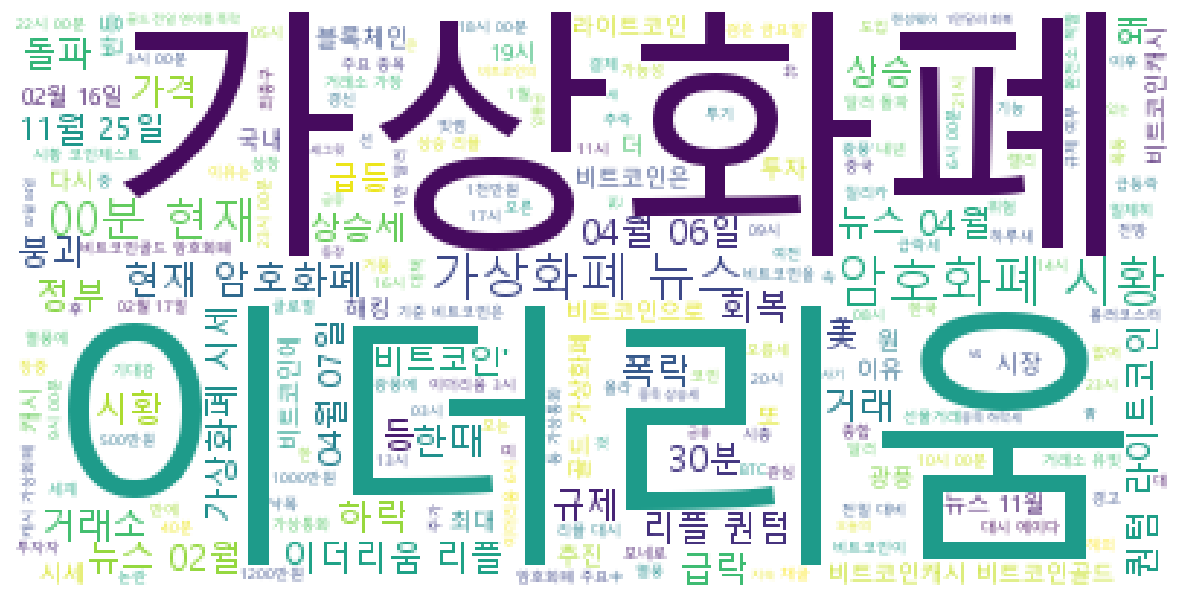

In [18]:
# ÏõåÎìúÌÅ¥ÎùºÏö∞ÎìúÎ•º ÌÜµÌïú ÌïµÏã¨ ÌÇ§ÏõåÎìú ÏãúÍ∞ÅÌôî
text = ",".join(news_titles)
f_path = "C:\Windows\Fonts\malgun.ttf"

wc = WordCloud(font_path = f_path, random_state = 42, background_color = "white", stopwords = ["ÎπÑÌä∏ÏΩîÏù∏"]).generate(text)
plt.figure(figsize = (15, 10))
plt.axis("off")
plt.imshow(wc, interpolation = "None")
plt.show()